## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, pickle, math
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import workspace_utils
from workspace_utils import active_session

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [3]:
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, roc_auc_score
import sklearn.model_selection as skl

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[1])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 12


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
50232,00012704_010.png,Nodule,10,12704,36,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012704_010.png
70601,00017410_004.png,No Finding,4,17410,42,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017410_004.png
2728,00000723_003.png,Effusion|Fibrosis,3,723,41,M,PA,2048,2500,0.171,0.171,NaN,/data/images_001/images/00000723_003.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
findings = set()
for f in all_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses: {len(findings)}')

Total number of single diagnoses: 15


In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

for finding in findings:
    all_xray_df[finding] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

In [7]:
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Cardiomegaly,No Finding,Mass,Edema,Infiltration,Consolidation,Emphysema,Pneumonia,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,N
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [8]:
def print_split_ratio(split_df, df):
    ylen = len(split_df[split_df['pneumonia_class'] == 'Y'])
    nlen = len(split_df[split_df['pneumonia_class'] == 'N'])
    print("length of data {} which is {:.2f}% of the total data.".format(len(split_df), len(split_df)/len(df)*100))
    print("length Y = {}, length N = {}".format(ylen, nlen))
    print("%Y = {:.2f}, %N = {:.2f}".format(ylen/len(split_df)*100, nlen/len(split_df)*100))

## Create your training and testing data:

In [9]:
def create_splits(**vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    df = vargs['df']
    
    train_df, valid_df = skl.train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    
    print("original data frame:")
    print_split_ratio(df, df)
    print()
    print("train data frame:")
    print_split_ratio(train_df, df)
    print()
    print("valid data frame:")
    print_split_ratio(valid_df, df)
    print()

    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Initial split. Train set pneumonia: {100.0*train_df_ratio :.2f}%. Valid set pneumonia: {100.0*valid_df_ratio :.2f}%')
    
    # make training set contain same number of positive and negative cases
    train_pos_inds = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    train_neg_inds = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()
    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_df = train_df.loc[train_pos_inds + train_neg_sample]
    
    print("\ntrain data frame after 50/50 Y and N split:")
    print_split_ratio(train_df, df)
    print()

    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'Train set corrected (50/50), pneumonia: {100.0*train_df_ratio :.2f}%')
    
    # make validation set contain 20% positive and 80% negative cases
    valid_pos_inds = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    valid_neg_inds = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    print("\ntrain data frame after 50/50 Y and N split:")
    print_split_ratio(train_df, df)
    print()
    
    valid_neg_sample = sample(valid_neg_inds, 4*len(valid_pos_inds))
    valid_df = valid_df.loc[valid_pos_inds + valid_neg_sample]
    
    print("valid data frame after 80/20 Y and N split:")
    print_split_ratio(valid_df, df)
    print()

    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Valid set corrected (20/80), pneumonia: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df

In [10]:
df_train, df_valid = create_splits(df = all_xray_df)
print(f'Train set size: {len(df_train)}, valid set size: {len(df_valid)}')

original data frame:
length of data 112120 which is 100.00% of the total data.
length Y = 1431, length N = 110689
%Y = 1.28, %N = 98.72

train data frame:
length of data 89696 which is 80.00% of the total data.
length Y = 1145, length N = 88551
%Y = 1.28, %N = 98.72

valid data frame:
length of data 22424 which is 20.00% of the total data.
length Y = 286, length N = 22138
%Y = 1.28, %N = 98.72

Initial split. Train set pneumonia: 1.28%. Valid set pneumonia: 1.28%

train data frame after 50/50 Y and N split:
length of data 2290 which is 2.04% of the total data.
length Y = 1145, length N = 1145
%Y = 50.00, %N = 50.00

Train set corrected (50/50), pneumonia: 50.00%

train data frame after 50/50 Y and N split:
length of data 2290 which is 2.04% of the total data.
length Y = 1145, length N = 1145
%Y = 50.00, %N = 50.00

valid data frame after 80/20 Y and N split:
length of data 1430 which is 1.28% of the total data.
length Y = 286, length N = 1144
%Y = 20.00, %N = 80.00

Valid set corrected

In [11]:
df_valid.to_csv('pneumonia_valid.csv', index=False)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
IMAGE_SIZE = (224, 224)

def train_data_aug(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    rotation = vargs['rotation'] if 'rotation' in vargs else 5
    shear = vargs['shear'] if 'shear' in vargs else 0.05
    zoom = vargs['zoom'] if 'rotation' in vargs else 0.05
    gen = ImageDataGenerator(
        rescale = 1./255.0,
        horizontal_flip = True, 
        vertical_flip = False, 
        rotation_range = rotation, 
        shear_range = shear,
        zoom_range = zoom)
    return gen

def val_data_aug(**vargs):
    gen = ImageDataGenerator(
        rescale=1./255.0
    )
    return gen

def make_train_gen(**vargs):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    df = vargs['df']
    aug = train_data_aug(**vargs)
    train_gen = aug.flow_from_dataframe(
        dataframe = df, 
        directory = None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE, 
        batch_size = 32)
    return train_gen

def make_val_gen(**vargs):
    df = vargs['df']
    aug = val_data_aug(**vargs)
    valid_gen = aug.flow_from_dataframe(
        dataframe = df, 
        directory = None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE, 
        batch_size = 1024)
    return valid_gen

In [13]:
train_gen = make_train_gen(df = df_train)
val_gen = make_val_gen(df = df_valid)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
valX.shape

(1024, 224, 224, 3)

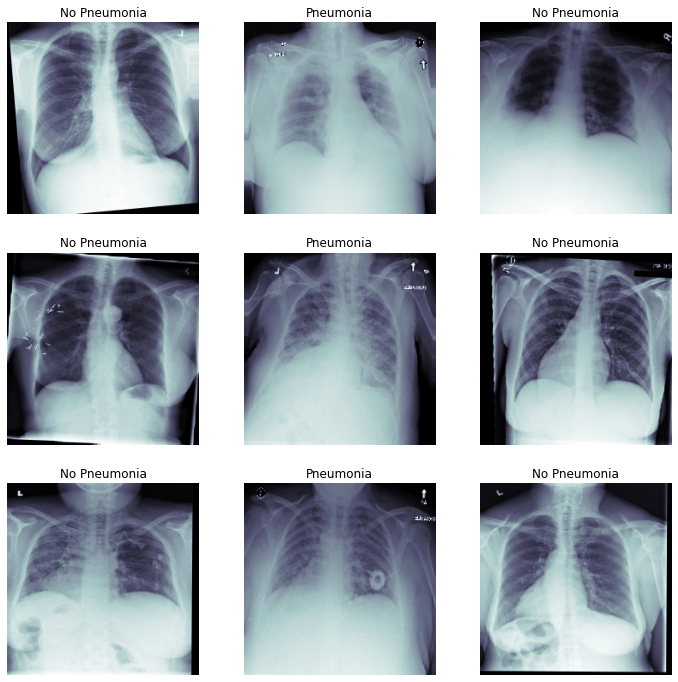

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (12, 12))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
fig.savefig('X-ray-samples.png')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_model(**vargs):
    vgg_16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in vgg_16.layers[0:17]:
        layer.trainable = False

    return vgg_16

In [17]:
def build_model(**vargs):
    
# my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # learning_rate = vargs['learning_rate'] if 'learning_rate' in vargs else 1e-4
    
    model = Sequential()
    model.add(load_pretrained_model())

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))    
    return model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [18]:
model = build_model()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_______________________________________________________

In [19]:
model.compile(optimizer=Adam(lr=1e-5), 
              loss='binary_crossentropy', 
              metrics=['binary_accuracy'])

In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

timestamp = time.strftime('%Y%m%d%H%M')
weight_path="./weights/{}_model.best{}.hdf5".format('xray_classification', timestamp )

model.compile(optimizer=Adam(lr=1e-5), 
              loss='binary_crossentropy', 
              metrics=['binary_accuracy'])

checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', 
                             mode = 'min', verbose = 1, 
                             save_best_only = True, 
                             save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=5)
callbacks_list = [checkpoint, early]

### Start training! 

In [43]:
## train your model

# Todo

# train your model
with active_session():
    history = model.fit(train_gen, 
                        validation_data = (valX, valY), epochs = 20,
                        callbacks = callbacks_list)

Epoch 1/20
72/72 [==============================] - 71s 987ms/step - loss: 0.7142 - binary_accuracy: 0.5148 - val_loss: 0.7025 - val_binary_accuracy: 0.5244

Epoch 00001: val_loss improved from inf to 0.70250, saving model to ./weights/xray_classification_model.best202010251022.hdf5
Epoch 2/20
72/72 [==============================] - 60s 840ms/step - loss: 0.6961 - binary_accuracy: 0.5397 - val_loss: 0.6709 - val_binary_accuracy: 0.5752

Epoch 00002: val_loss improved from 0.70250 to 0.67093, saving model to ./weights/xray_classification_model.best202010251022.hdf5
Epoch 3/20
72/72 [==============================] - 59s 822ms/step - loss: 0.6740 - binary_accuracy: 0.5721 - val_loss: 0.6905 - val_binary_accuracy: 0.5391

Epoch 00003: val_loss did not improve from 0.67093
Epoch 4/20
72/72 [==============================] - 61s 840ms/step - loss: 0.6797 - binary_accuracy: 0.5694 - val_loss: 0.6893 - val_binary_accuracy: 0.5439

Epoch 00004: val_loss did not improve from 0.67093
Epoch 5/20

In [64]:
pkl_filename = "./history/history{}.pkl".format(timestamp)
with open(pkl_filename, 'wb') as file:
    pickle.dump(history.history, file)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [21]:
model_history = history.history

In [22]:
# ! ls ./history -lt
# print()
# data_dir = './history'
# extension = 'pkl'
# image_files = glob(os.path.join(data_dir, '*.{}'.format(extension)))

# for i, file in enumerate(image_files):
#     print(i,"  ", image_files[i])

total 16
-rw-r--r-- 1 root root 1339 Oct 25 10:43 history202010251022.pkl
-rw-r--r-- 1 root root 1165 Oct 25 09:54 history202010250927.pkl
-rw-r--r-- 1 root root 1107 Oct 25 07:32 history202010250716.pkl
-rw-r--r-- 1 root root  291 Oct 25 06:40 history202010250530.pkl

0    ./history/history202010251022.pkl
1    ./history/history202010250927.pkl
2    ./history/history202010250716.pkl
3    ./history/history202010250530.pkl


In [23]:
# with open(image_files[0], 'rb') as file:
#     model_history = pickle.load(file)

In [24]:
# ! ls ./weights -lt
# print()
# data_dir = "./weights"
# extension = 'hdf5'
# image_files = glob(os.path.join(data_dir, '*.{}'.format(extension)))

# for i, file in enumerate(image_files):
#     print(i,"  ", image_files[i])

total 321224
-rw-r--r-- 1 root root 164294880 Oct 25 10:37 xray_classification_model.best202010251022.hdf5
-rw-r--r-- 1 root root 164294880 Oct 11 04:55 xray_classification_model.best202010110429.hdf5

0    ./weights/xray_classification_model.best202010251022.hdf5
1    ./weights/xray_classification_model.best202010110429.hdf5


In [25]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

# model.load_weights(image_files[0])
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 560s 547ms/step


In [26]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
#     for i,k in enumerate(thresholds):
#         print(i, fpr[i], tpr[i], thresholds[i])
    f = plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve') 
    f.savefig('ROC-curve.png')
    plt.show()
## what other performance statistics do you want to include here besides AUC? 
def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    f = plt.figure(figsize=(6,4))
    plt.plot(recall[2:-2], precision[2:-2], color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    f.savefig('PR-curve.png')
    plt.show()

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

#Also consider plotting the history of your model training:

def plot_history(history):
    f = plt.figure(figsize=(12,5))
#     f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.plot(model_history['val_loss'], label='val loss')
    plt.plot(model_history['loss'], label='train loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('epoch vs loss')
    plt.xticks(np.arange(0, 20, 2))
    plt.legend()

    f.add_subplot(1, 2, 2)
    plt.plot(model_history['val_binary_accuracy'], label='val accuracy')
    plt.plot(model_history['binary_accuracy'], label='train accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('epoch vs accuracy')
    plt.xticks(np.arange(0, 20, 2))
    plt.legend()

    f.savefig('plot_history.png')
    plt.show()
    return

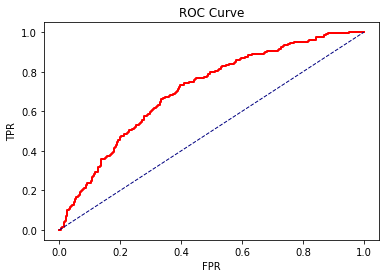

0.7063589563589564

In [27]:
## plot figures
plot_auc(valY, pred_Y)
roc_auc_score(valY, pred_Y)

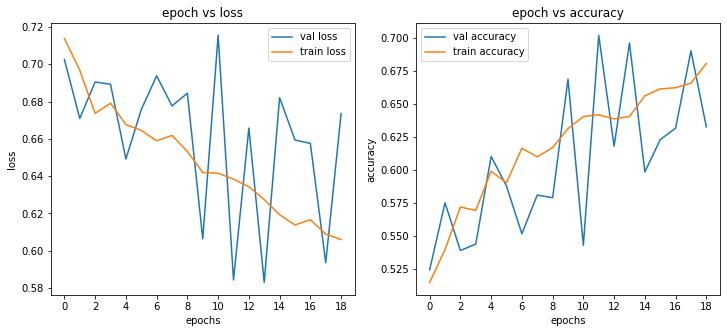

In [28]:
plot_history(model_history)

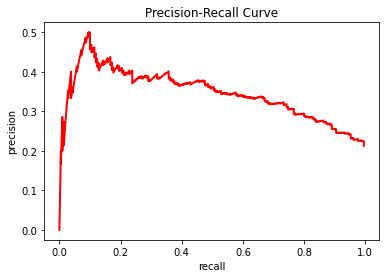

In [29]:
plot_pr(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

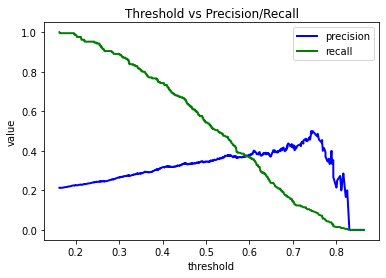

In [30]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
f = plt.figure(figsize=(6,4))
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Threshold vs Precision/Recall')
f.savefig('PR_Thresh.png')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


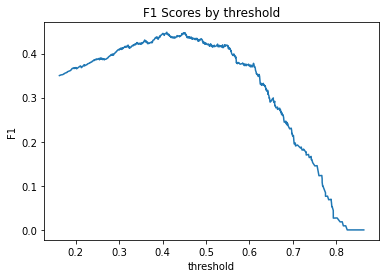

In [31]:
def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]

fig = plt.figure(figsize=(6,4))
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
fig.savefig('F1-Thresh.png')
plt.show()

In [32]:
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]

print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}')

Max F1 score: 0.448, threshold: 0.410, precision: 0.322, recall: 0.733


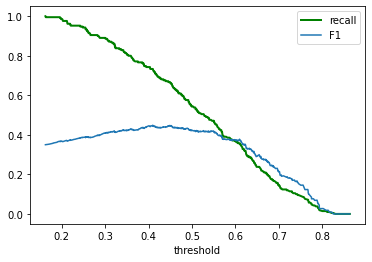

In [33]:
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, label='F1')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [34]:
th_opt = thresholds[ind]
th_opt1 = th_opt - 0.02*5
th_opt2 = th_opt + 0.02*5
th_opt_range = np.linspace(th_opt1, th_opt2, 10).tolist()
th_opt_range = sorted(th_opt_range + [th_opt])

In [35]:
def get_index(th):
    for i,t in enumerate(thresholds):
        if t > th:
            return i
   
for th in th_opt_range:
    print("Recall: {:.3f}, precision: {:.3f}, F1: {:.3f}, threshold: {:.3f}".format(
            recall[get_index(th)],
            precision[get_index(th)],
            f1scores[get_index(th)],
            thresholds[get_index(th)]))

Recall: 0.871, precision: 0.270, F1: 0.413, threshold: 0.310
Recall: 0.838, precision: 0.279, F1: 0.419, threshold: 0.332
Recall: 0.800, precision: 0.289, F1: 0.425, threshold: 0.356
Recall: 0.767, precision: 0.294, F1: 0.426, threshold: 0.377
Recall: 0.743, precision: 0.316, F1: 0.444, threshold: 0.399
Recall: 0.733, precision: 0.323, F1: 0.446, threshold: 0.410
Recall: 0.695, precision: 0.319, F1: 0.438, threshold: 0.422
Recall: 0.671, precision: 0.329, F1: 0.442, threshold: 0.444
Recall: 0.624, precision: 0.336, F1: 0.437, threshold: 0.466
Recall: 0.576, precision: 0.346, F1: 0.433, threshold: 0.488
Recall: 0.529, precision: 0.348, F1: 0.420, threshold: 0.510


In [41]:
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > 0.356).astype(int)).ravel()
tn, fp, fn, tp

(401, 413, 42, 168)

In [42]:
print(f'negative predictive value (NPV), TN/(TN+FN) = {tn/(tn+fn)}')

negative predictive value (NPV), TN/(TN+FN) = 0.9051918735891648


In [43]:
YOUR_THRESHOLD = 0.356
testY = valY
valX[1][:,:,0].shape

(224, 224)

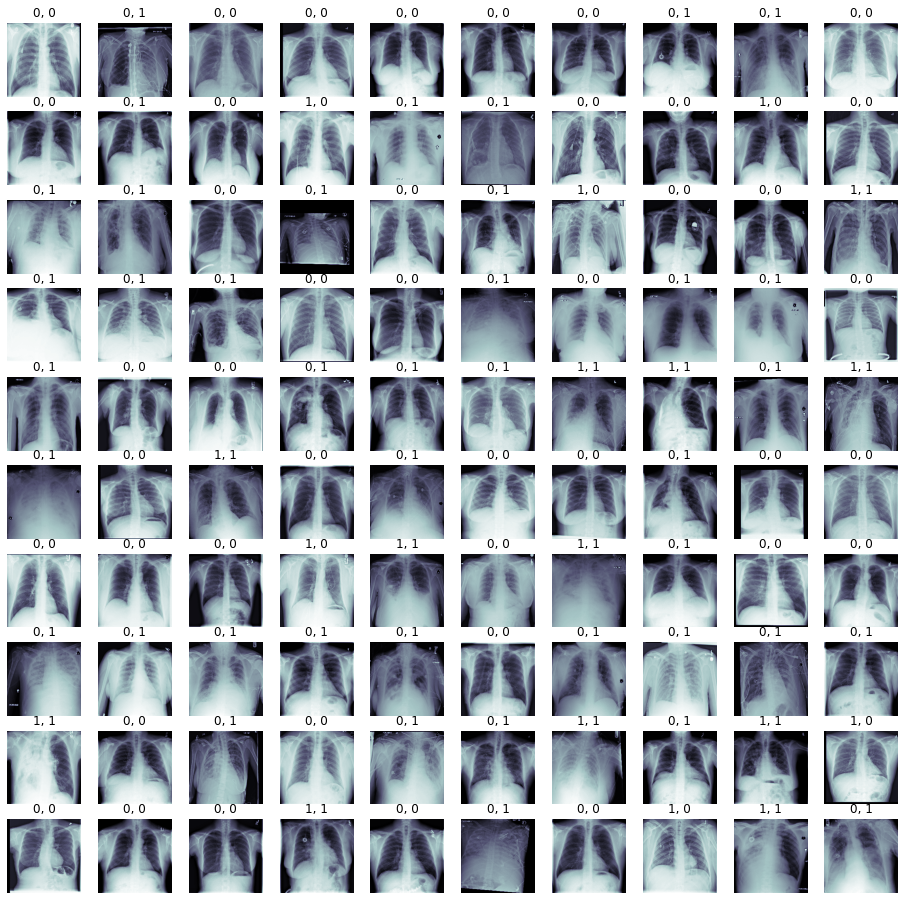

In [44]:
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [45]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("xray_classification_model.json", "w") as json_file:
    json_file.write(model_json)